In [1]:
import os
os.chdir("..")

In [2]:
from implicit_filter import CuPyFilter, convert_to_wavenumbers, make_tri
import math
import numpy as np

# Create mesh
---

### Define mesh parameters

In [3]:
# ============
# Mesh size:
# ============
Lx = 2000
Ly = Lx
# ===========
# Cell size and x,y vectors
# ===========
dxm = 1
dym = dxm
cyclic = 0  # 1 if mesh is cyclic
cyclic_length = 360  # in degrees; if not cyclic, take it larger than  zonal size
cyclic_length = cyclic_length * math.pi / 180  # DO NOT TOUCH
meshtype = 'm'  # coordinates can be in physical measure 'm' or in radians 'r'
cartesian = False
r_earth = 6400

### Create mesh

In [4]:
xx = np.arange(0, Lx + 1, dxm)
yy = np.arange(0, Ly + 1, dym)

nx = len(xx)
ny = len(yy)
# =============
# 2D regular array of points,
# their x and y coordinates.
# We will create triangles later
# =============

nodnum = np.arange(0, nx * ny)
xcoord = np.zeros((ny, nx))
ycoord = xcoord.copy()

for i in range(nx):
    ycoord[i, :] = yy

for i in range(ny):
    xcoord[:, i] = xx

### Create sythetic data

This process is executed asynchronously to create multiple input data

In [5]:
def make_data():
    tt = 50 * (np.random.random(xcoord.shape) - 0.5)
    ttf = np.fft.fft2(tt)
    # ============
    # Make spectrum red
    # ============
    espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
    kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers
    
    for mx in range(nx):
        for my in range(ny):
            ll = np.sqrt(kk[my] * kk[my] + kk[mx] * kk[mx])  # Absolute value
            if my == 0 and mx == 0:  # Remove area mean
                ttf[my, mx] = 0.0
            else:  # Adjust amplitudes
                tmp = ttf[my, mx] / (np.power(ll, 1.5))  # 1.5 for -2 spectrum
                ttf[my, mx] = tmp
            if ll + 1 <= nx // 2 + 1:
                espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])
    
    espectrum = espectrum / np.power(nx, 4)
    tt = np.real(np.fft.ifft2(ttf))
    tt = np.reshape(tt, [nx * ny])
    return tt # We expect that it will show - 2 spectrum

In [6]:
%%time

import concurrent
import warnings
warnings.filterwarnings('ignore')

futures = []
with concurrent.futures.ProcessPoolExecutor() as executor:
    
    for i in range(40):
        futures.append(executor.submit(make_data))
    
    executor.shutdown(wait=True)

CPU times: user 280 ms, sys: 1.49 s, total: 1.77 s
Wall time: 29.3 s


In [7]:
data = []
for f in futures:
    data.append(f.result())

### Reshape arrays and load_from_fileate triangulation

In [8]:
nodnum = np.reshape(nodnum, [ny, nx]).T
xcoord = np.reshape(xcoord, [nx * ny])
ycoord = np.reshape(ycoord, [nx * ny])

In [9]:
tri = make_tri(nodnum, nx, ny)
n2d = len(xcoord)  # The number of vertices(nodes)
e2d = len(tri[:, 1])

# Filtering
---

### Define wavelength

Using build-in function to get wavenumber corresponding to 100 km filter

In [10]:
Kc = convert_to_wavenumbers(500, dxm)

In [11]:
%%time
jf = CuPyFilter.load_from_file("tmp.npz")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


CPU times: user 385 ms, sys: 321 ms, total: 706 ms
Wall time: 710 ms


In [14]:
jf.save_to_file("tmp")

Comparing simple for-loop based implementation with optimized method

In [16]:
%%time

output = []
for tt, i in zip(data, range(len(data))):
        tts = jf.compute(1, Kc, tt)
        output.append(tts)

CPU times: user 1min 33s, sys: 57 ms, total: 1min 33s
Wall time: 1min 34s


In [12]:
%%time
output = jf.many_compute(1, Kc, data)

CPU times: user 1min 21s, sys: 16.7 s, total: 1min 37s
Wall time: 1min 5s


In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [14]:
triang = mpl.tri.Triangulation(xcoord, ycoord, tri)

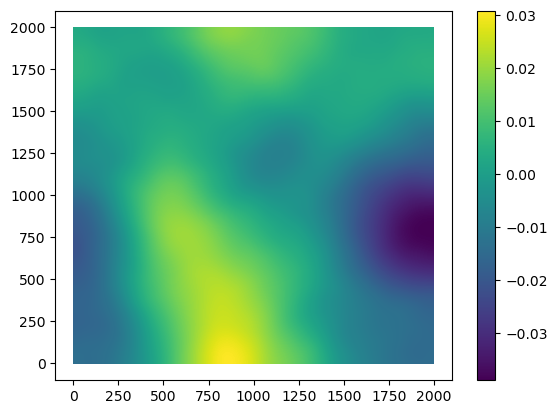

In [15]:
plt.tripcolor(triang, output[-2])
plt.colorbar()